In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import importlib as imp
import seaborn as sns
from tifffile import TiffFile
import umap
import pickle

Xenium initial pixel size 0.2125 microns.
Reduce the size to 1/4. Pizel size 0.85 microns.
Visium pixel size 55/73.06=0.7528 microns.

In [2]:
adata_xe = sc.read_10x_h5(filename='F:/Ziqian Zheng/Spatial omics/Xenium/B1/cell_feature_matrix.h5')
df = pd.read_csv('F:/Ziqian Zheng/Spatial omics/Xenium/B1/cells.csv')
df.set_index(adata_xe.obs_names, inplace=True)
adata_xe.obs = df.copy()
adata_xe.obsm["spatial"] = adata_xe.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
coordinate_xe = adata_xe.obsm["spatial"]

adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad")
common_gene = list(set(adata_xe.var_names) & set(adata_sc.var_names))
adata_sc = adata_sc[:, common_gene]
adata_xe = adata_xe[:, common_gene]

type_list = sorted(list(np.unique(adata_sc.obs['Allen.subclass_label'])))
n_type = len(type_list)
adata_xe.uns['type_list'] = type_list

C:\Users\zzheng92\AppData\Local\Temp\3\ipykernel_14284\3350876131.py:15: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_xe.uns['type_list'] = type_list


In [3]:
X_train = adata_sc.X.toarray()
X_test = adata_xe.X.toarray()
y_train = adata_sc.obs['Allen.subclass_label'].to_numpy()

In [4]:
X_train = 1000*X_train/(np.sum(X_train, axis=1, keepdims=True)+1e-8)
X_test = 1000*X_test/(np.sum(X_test, axis=1, keepdims=True)+1e-8)

In [5]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=16)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
adata_xe.obs['cell_type'] = y_pred
adata_xe.obs['cell_type'].value_counts()

CPU times: total: 7min 52s
Wall time: 32 s


<timed exec>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


cell_type
Astro         29923
Oligo         18664
L2/3 IT       15386
L6 CT          7369
Endo           5650
L5 IT          4633
Macrophage     4212
VLMC           3688
Pvalb          3265
Sst            3020
OPC            2596
L6 IT          1814
Lamp5          1546
L5 ET           824
Vip             777
L5/6 NP         423
Prog/IP         407
L6b             319
Peri            243
Sncg             72
Name: count, dtype: int64

In [6]:
adata_xe_copy = adata_xe.copy()
sc.pp.normalize_per_cell(adata_xe_copy, counts_per_cell_after=1e4)
# sc.pp.log1p(adata_xe_copy)
adata_xe_copy.raw = adata_xe_copy
sc.pp.neighbors(adata_xe_copy, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_xe_copy)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [7]:
with mpl.rc_context({'figure.figsize': [10, 10], 'figure.dpi': 400}):
    sc.pl.umap(adata_xe_copy, color='cell_type', size=6)

C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [8]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.log(X_test+1))
embedding_df = pd.DataFrame({'x':embedding[:, 0], 'y':embedding[:, 1], 'cell_type':adata_xe.obs['cell_type']})
embedding.shape

(104831, 2)

In [9]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
sns.palplot(contrast_palette)

In [10]:
# import colorcet as cc
# palette = sns.color_palette(cc.glasbey, n_colors=20)
# sns.palplot(palette)
plt.figure(figsize=(11, 10), dpi=300)
ax = sns.scatterplot(data = embedding_df, x='x', y='y', s=1, hue='cell_type', palette=contrast_palette)
# ax = sns.scatterplot(data = embedding_df, x='x', y='y', s=0.3, hue='cell_type', palette=sns.color_palette())
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('results/Xenium/umap_xenium.tiff', dpi=1000, bbox_inches = 'tight')

C:\Users\zzheng92\AppData\Local\Temp\3\ipykernel_21512\3018446317.py:5: UserWarning: The palette list has more values (25) than needed (20), which may not be intended.
  ax = sns.scatterplot(data = embedding_df, x='x', y='y', s=1, hue='cell_type', palette=contrast_palette)


In [11]:
type_list_xe = list(sorted(adata_xe.obs['cell_type'].unique()))
X_test_mean = np.zeros((len(type_list_xe), X_test.shape[1]))
for i, type_ in enumerate(type_list_xe):
    X_test_mean[i] = np.mean(X_test[y_pred==type_], axis=0)
X_test_mean_argmax = np.argmax(X_test_mean, axis=0)
X_test_sort = X_test[np.argsort(y_pred)]
X_test_sort = X_test_sort[:, np.argsort(X_test_mean_argmax)]
X_train_sort = X_train[np.argsort(y_train)]
X_train_sort = X_train_sort[:, np.argsort(X_test_mean_argmax)]

In [12]:
# fig, ax = plt.subplots(1, 1, figsize=(40, 8), dpi=50)
# palette = sns.cubehelix_palette(n_type, light=.9, dark=.1, reverse=True, start=1, rot=-2)
palette_dict = dict(zip(map(str, type_list), contrast_palette))
col_colors = adata_xe.obs['cell_type'].sort_values().map(palette_dict).to_numpy()
g = sns.clustermap(X_test_sort.T, vmax=40, row_cluster=False, col_cluster=False, xticklabels=False, yticklabels=False,
                   figsize=(16, 10), col_colors=col_colors)
for label in type_list:
    g.ax_col_dendrogram.bar(0, 0, color=palette_dict[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .01, .45])
plt.savefig('results/Xenium/heatmap_xe.tiff', dpi=1000, bbox_inches = 'tight')

In [13]:
col_colors = adata_sc.obs['Allen.subclass_label'].sort_values().map(palette_dict).to_numpy()
g = sns.clustermap(X_train_sort.T, vmax=40, row_cluster=False, col_cluster=False, xticklabels=False, yticklabels=False,
                   figsize=(16, 10), col_colors=col_colors)
for label in type_list:
    g.ax_col_dendrogram.bar(0, 0, color=palette_dict[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .01, .45])
plt.savefig('results/Xenium/heatmap_sc.tiff', dpi=1000, bbox_inches = 'tight')

In [3]:
with TiffFile('F:/Ziqian Zheng/Spatial omics/Xenium/B1/morphology_mip.ome.tif') as tif:
    Xenium = tif.asarray()
del tif
# Initially, the pixel size of Xenium 0.2125 microns.
Xenium = Xenium[::4, ::4]  # Make the size of the image to be 1/4. Now the pixel size is 0.85 microns.

In [4]:
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st.var_names_make_unique()
adata_st.uns['type_list'] = type_list
coordinate_st = adata_st.obsm["spatial"]

C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
HE = cv.imread('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
HE = HE[:, :, [2, 1, 0]]

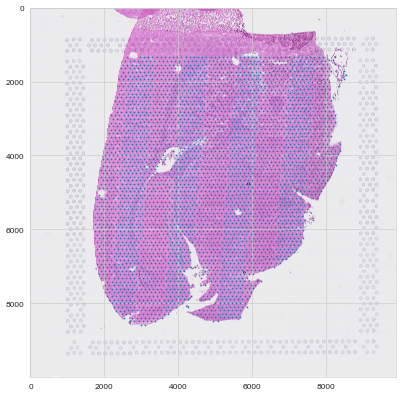

In [6]:
plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(HE)
plt.scatter(coordinate_st[:, 0], coordinate_st[:, 1], s=1)

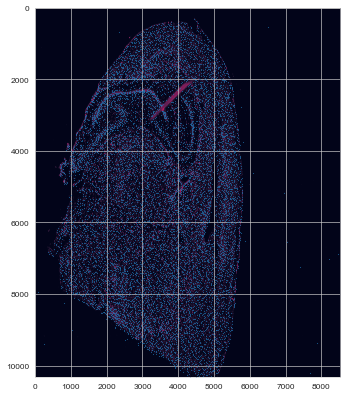

In [7]:
plt.figure(figsize=(9, 8), dpi=60)
plt.imshow(Xenium)
plt.scatter(coordinate_xe[::10, 0]/0.85, coordinate_xe[::10, 1]/0.85, s=0.1)
# plt.scatter(1000, 4000)

In [8]:
# Visium pixel size 0.7528 microns.
Xenium_resize = cv.resize(Xenium, None, fx=0.85/0.7528, fy=0.85/0.7528, interpolation=cv.INTER_CUBIC)
rows , cols = HE.shape[:2]
theta = 3.37
trans = [7050, 10550]
M = np.float32([[np.cos(theta), -np.sin(theta), trans[0]], [np.sin(theta), np.cos(theta), trans[1]]])
Xenium_resize_Affine = cv.warpAffine(Xenium_resize, M, (cols, rows))
coordinate_xe_resize = coordinate_xe/0.7528
coordinate_xe_rotate = coordinate_xe_resize @ M[:, :2].T + trans
adata_xe.obs[['x_centroid', 'y_centroid']] = coordinate_xe_rotate

C:\Users\zzheng92\AppData\Local\Temp\3\ipykernel_14284\3419089831.py:8: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object, name=cmap_name)


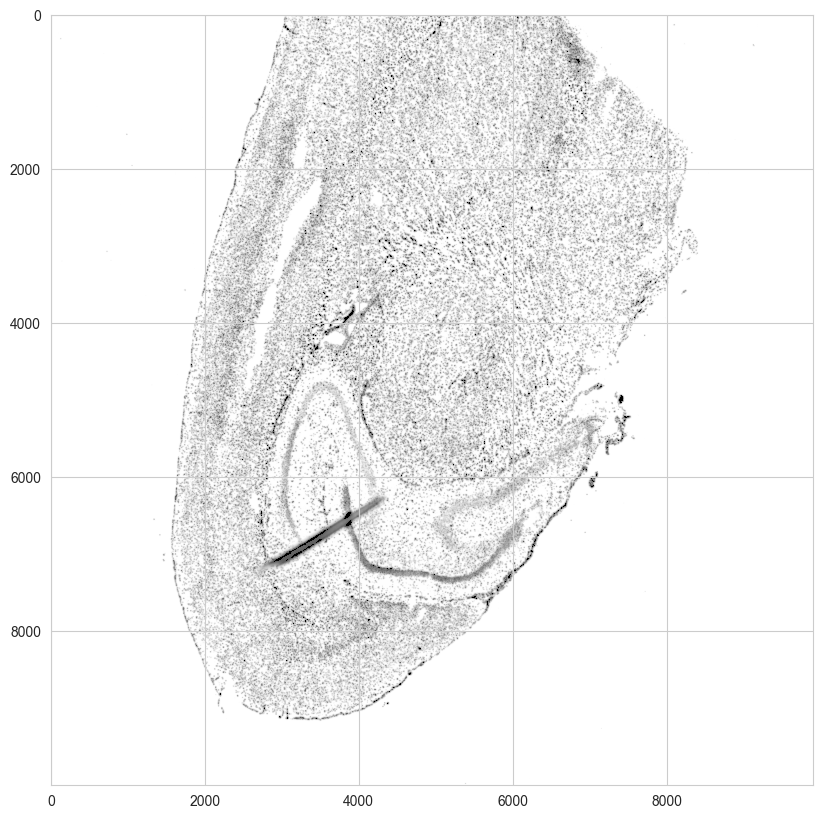

In [11]:
from matplotlib.colors import LinearSegmentedColormap
n_colors = np.max(Xenium)
color_array = plt.get_cmap('binary')(range(n_colors))
color_array[:,-1] = np.linspace(0, 2.0, n_colors)
color_array[n_colors//3-1:,-1] = 1
cmap_name = 'binary_alpha'
map_object = LinearSegmentedColormap.from_list(name=cmap_name, colors=color_array)
plt.register_cmap(cmap=map_object, name=cmap_name)
plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(HE, alpha=1)
plt.imshow(Xenium_resize_Affine, alpha=1, cmap=cmap_name)
plt.savefig('Xenium_affine.jpg', dpi=2000)

In [21]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(Xenium_resize_Affine, alpha=1, cmap=cmap_name)
plt.scatter(coordinate_xe_rotate[::10, 0], coordinate_xe_rotate[::10, 1], s=0.1)
plt.scatter(coordinate_st[:, 0], coordinate_st[:, 1], s=1)

In [22]:
# Xenium_resize_Affine = np.save('results/Xenium/Xenium_resize_Affine.npy', Xenium_resize_Affine)

In [ ]:
distance = np.sum((coordinate_st[:, :, np.newaxis] - coordinate_xe_rotate.T) ** 2, axis=1)
truth_df = pd.DataFrame({type_: [0]*len(adata_st) for type_ in type_list})
truth_df.index = adata_st.obs_names
for i in range(len(adata_st)):
    cell_index = np.where(distance[i] < 36.5**2)[0]
    if len(cell_index) > 0:
        cells = adata_xe.obs['cell_type'].to_numpy()[cell_index]
        for cell in cells:
            truth_df.iloc[i, truth_df.columns.get_loc(cell)] += 1
adata_st.obsm['truth'] = truth_df

In [ ]:
row_sum = np.sum(truth_df.to_numpy(), axis=1)
row_sum[row_sum<1] = 1
truth_normalized = truth_df/row_sum[:, np.newaxis]
adata_st.obs[type_list] = truth_df.to_numpy()

In [ ]:
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g', 'Sncg': 'Sncg_g'}, inplace=True)
vmax = np.quantile(adata_st.obs[type_list].to_numpy(), 0.98, axis=0)
vmax[vmax < 1] = 1

In [ ]:
Xenium_resize_Affine_copy = Xenium_resize_Affine.copy()
threshold = 1500
Xenium_resize_Affine_copy[Xenium_resize_Affine_copy>threshold] = threshold
Xenium_resize_Affine_copy = threshold - Xenium_resize_Affine_copy
Xenium_resize_Affine_copy = np.clip(Xenium_resize_Affine_copy * (255 / np.max(Xenium_resize_Affine_copy)), 0, 255).astype(np.uint8)
Xenium_background = cv.cvtColor(Xenium_resize_Affine_copy, cv.COLOR_GRAY2RGB)

In [ ]:
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 400}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list, vmin=0, vmax=list(vmax), size=1.3, show=False, ncols=5, img=Xenium_background, scale_factor=1)
    ax[0].get_figure().savefig('results/Xenium/number.tiff')

In [ ]:
adata_st.write_h5ad('results/Xenium/adata_st.h5ad')

In [28]:
adata_xe.write_h5ad('results/Xenium/adata_xe.h5ad')